# Sensitivity of Fold-Change to $F$

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [355]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mut.thermo
import mut.bayes
import mut.viz
import tqdm
pboc = mut.viz.color_selector('pboc')

constants = mut.thermo.load_constants()
mut.viz.plotting_style()

In my analysis, I have found that at the extremes of fold-change the $\Delta F$ is poorly resolved and has aninteresting trend towards $\Delta F = 0$. I think this has something to do with the fact that when you approach the asymptotes of fold-change, the magnitude of the empirical $F$ gets very large. As a reminder, the empirical $F$ can be calculated from the fold-change data as

$$
F_\text{empirical} = \log \left( {1 \over \text{fold-change}} -1\right)
$$

# Generating a fake data set
We can generate a dataset in which fold-change measurements are normally distributed about a value prescribed by the theory. 

In [839]:
sigma = 0.05
n_reps = 5
true_bohr = np.linspace(-30, 30, 100)
dataset_fc = []
fc_mu = (1 + np.exp(-true_bohr))**-1
for i, b in enumerate(true_bohr):
    mu = (1 + np.exp(-b))**-1
    dataset = np.random.normal(mu, sigma, n_reps)
    df = pd.DataFrame(dataset.T, columns=['fold_change'])
    df['replicate'] = np.arange(n_reps)
    df['true_bohr'] = b
    dataset_fc.append(df)
dataset = pd.concat(dataset_fc)

In [840]:
# Load the stan model
model = mut.bayes.StanModel('../stan/empirical_F.stan', force_compile=True)
stan_dfs = []
for g, d in dataset.groupby('true_bohr'):
    data_dict = {'N':len(d), 'ref_bohr':g, 'foldchange':d['fold_change']}
    fit, samples = model.sample(data_dict, control=dict(adapt_delta=0.95))
    stats = mut.stats.compute_statistics(samples, varnames=['fc_mu', 'fc_sigma',
                                                           'empirical_bohr',
                                                            'delta_bohr'],
                                        logprob_name='lp__')
    stats['true_bohr'] = g
    stats['fc_mu_std'] = np.std(samples['fc_mu'])
    stan_dfs.append(stats)
stats = pd.concat(stan_dfs)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a42a12207f00ef77e779e021dcf7c804 NOW.


Precompiled model not found. Compiling model...


/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpc_pvhlmp/stanfit4anon_model_a42a12207f00ef77e779e021dcf7c804_8367552833239532596.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


finished!


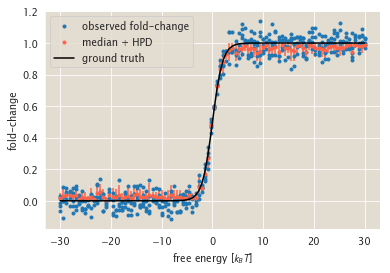

In [841]:
_fc_mu = stats[stats['parameter']=='fc_mu']
plt.plot(dataset['true_bohr'], dataset['fold_change'], '.', label='observed fold-change')
plt.plot(_fc_mu['true_bohr'], _fc_mu['mean'], '.', color='tomato', label='median + HPD' )
plt.vlines(_fc_mu['true_bohr'], _fc_mu['hpd_min'], _fc_mu['hpd_max'], color='tomato', label='__nolegend__')
plt.plot(true_bohr, (1 + np.exp(-true_bohr))**-1, 'k-', label='ground truth')
plt.xlabel('free energy [$k_BT$]')
plt.ylabel('fold-change')
plt.legend()

Text(0, 0.5, '$\\Delta F$')

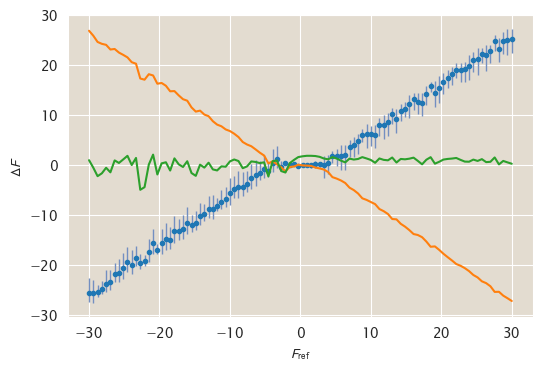

In [863]:
plt.figure(dpi=100)
dbohr = stats[stats['parameter']=='delta_bohr']
_sigma = stats[stats['parameter']=='fc_sigma']
_fc_mu = stats[stats['parameter']=='fc_mu']
plt.plot(true_bohr, dbohr['median'], '.')
plt.vlines(true_bohr, dbohr['hpd_min'], dbohr['hpd_max'], color=pboc['blue'], lw=1)
plt.plot(true_bohr, -true_bohr - np.log(np.sqrt(1/(_fc_mu['median'] - sigma)**2) - 1))
plt.plot(true_bohr, dbohr['median'] - (true_bohr + np.log((1/(_fc_mu['median'].values-sigma)**2) -1))+\
        np.log((1/sigma) -1))

plt.xlabel('$F_\mathrm{ref}$')
plt.ylabel('$\Delta F$')

Even with this fake data set, wherer the features of teh generating distribution are well controlled, I see that I have upper and lower limits to the values of the fold-change that can be inferred. To figure out what this limit is, we can run this inference over and over again on data sets where the sigma is changing. For this, I will choose one value for the bohr parameter that is close to saturating fold-change (say $8 k_BT$). 
tabi

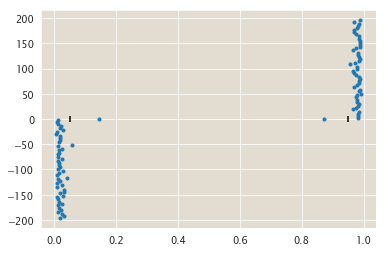

In [836]:
plt.plot(_fc_mu['median'], dbohr['median'], '.')
plt.vlines(0.05, -5, 5)
plt.vlines(0.95, -5, 5)

In [837]:
def zoff_error(fc, sigma, F_ref, F_emp):  
    dfc_df = np.exp(-F_ref) / (1 + np.exp(-F_ref))**2
    return F_ref + np.log((1/sigma) - 1)


Text(0, 0.5, '$\\Delta F$')

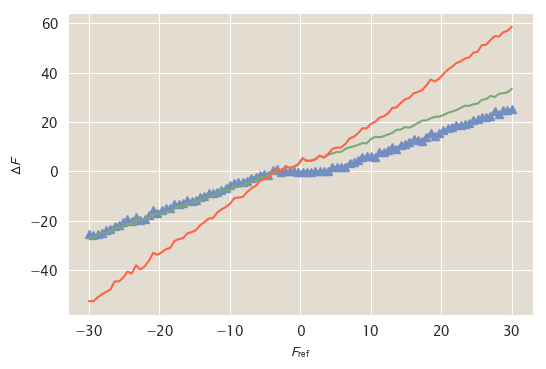

In [843]:
plt.figure(dpi=100)
dbohr = stats[stats['parameter']=='delta_bohr']
fc_mu = stats[stats['parameter']=='fc_mu']
emp_f = stats[stats['parameter']=='empirical_bohr']
fc_sigma = stats[stats['parameter']=='fc_sigma']
correction = zoff_error(fc_mu['median'].values, fc_sigma['median'].values, fc_mu['true_bohr'].values, emp_f['median'].values)
plt.plot(true_bohr, dbohr['median'], '-^', color=pboc['blue'])
plt.plot(true_bohr, correction, '-', color=pboc['green'])
plt.plot(true_bohr, dbohr['median'] + correction, color='tomato')
plt.xlabel('$F_\mathrm{ref}$')
plt.ylabel('$\Delta F$')

# plt.vlines(dbohr_corr['true_bohr'], dbohr_corr['hpd_min'], dbohr_corr['hpd_max'])

In [807]:
np.log((1/sigma) - 1)

2.9444389791664403

## Mapping inferential sensitifvity to the generating distribution

In [577]:
sigma_range = np.logspace(-4, 0, 100)
seed_bohr = 20 #in kBT
n_reps = 5 
n_sim = 1
fc_mu = (1 + np.exp(-seed_bohr))**-1 # The true fold-change distribution
sigma_df = []
sigma_stats = []
for j in tqdm.tqdm(range(n_sim)):
    for i, s in enumerate(tqdm.tqdm(sigma_range)):
        dataset = np.random.normal(fc_mu, s, n_reps)
        data_dict = {'N':n_reps, 'ref_bohr':seed_bohr, 'foldchange':dataset}
        fit, samples = model.sample(data_dict, control=dict(adapt_delta=0.99))
        stats = mut.stats.compute_statistics(samples, varnames=['fc_mu', 'fc_sigma', 
                                                                'delta_bohr',
                                                               'empirical_bohr'],
                                            logprob_name='lp__')
        stats['true_sigma'] = s
        stats['fc_mu_std'] = np.std(samples['fc_mu'])
        stats['delta_bohr_std'] = np.std(samples['delta_bohr'])
        stats['true_fc'] = fc_mu
        stats['generated_fc_mu'] = np.mean(dataset)
        stats['sim_number'] = j
        sigma_stats.append(stats)
sigma_stats = pd.concat(sigma_stats)
    


100%|██████████| 1/1 [00:34<00:00, 34.91s/it]


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


Text(0, 0.5, '$\\Delta F$ [$k_BT$]')

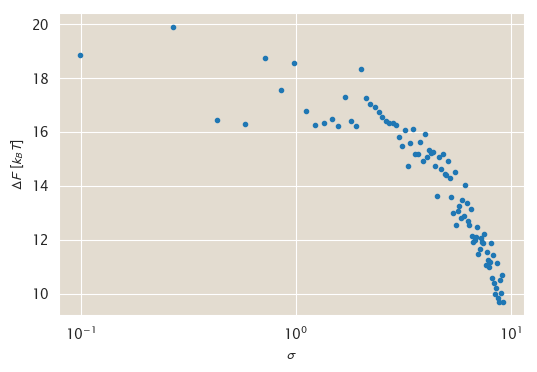

In [578]:
delta_bohr = sigma_stats[sigma_stats['parameter']=='delta_bohr'] 
fc_sigma = sigma_stats[sigma_stats['parameter']=='fc_sigma']
_fc_mu = sigma_stats[sigma_stats['parameter']=='fc_mu']
plt.figure(dpi=100)
plt.plot(np.log((1/_fc_mu['true_sigma']) - 1), delta_bohr['median'], '.')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$\sigma$')
plt.ylabel('$\Delta F$ [$k_BT$]')


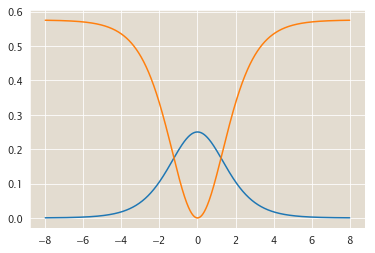

In [440]:
bohr_range = np.linspace(-8, 8, 1000)
dfc_df = np.exp(-bohr_range) / (1+np.exp(-bohr_range))**2
max_val = 1/4
err_func = (2 * np.heaviside(bohr_range, 1) - 1) * (max_val - dfc_df) * np.log(1E-1)
plt.plot(bohr_range, dfc_df)
plt.plot(bohr_range, err_func)
# plt.plot(bohr_range, 2 * np.heaviside(bohr_range, 1) - 1)

In [421]:
np.heaviside?

Call signature:  np.heaviside(*args, **kwargs)
Type:            ufunc
String form:     <ufunc 'heaviside'>
File:            /anaconda3/lib/python3.6/site-packages/numpy/__init__.py
Docstring:      
heaviside(x1, x2, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])

Compute the Heaviside step function.

The Heaviside step function is defined as::

                          0   if x1 < 0
    heaviside(x1, x2) =  x2   if x1 == 0
                          1   if x1 > 0

where `x2` is often taken to be 0.5, but 0 and 1 are also sometimes used.

Parameters
----------
x1 : array_like
    Input values.
x2 : array_like
    The value of the function when x1 is 0.
out : ndarray, None, or tuple of ndarray and None, optional
    A location into which the result is stored. If provided, it must have
    a shape that the inputs broadcast to. If not provided or `None`,
    a freshly-allocated array is returned. A tuple (possible only as a
    keyw

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


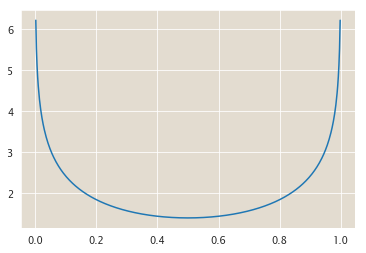

In [614]:
fc = np.linspace(0, 1, 500)
plt.plot(fc,np.log(-(fc**2 - fc)**-1))